# 1. Import Dependencies

In [1]:
from nes_py.wrappers import JoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import time
import matplotlib.pyplot as plt

import os

from gym_utils import SMBRamWrapper

D:\MarioPPO\Super-mario reinforcement learning\ppo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch. cuda. is_available()

True

In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-2-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# 2. Process Environment

In [4]:
# Setup cropping size
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4

env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)

In [5]:
# test env_wrap
done = True
for i in range(150):
    if done:
        state = env_wrap.reset()
    state, reward, done, info = env_wrap.step(env_wrap.action_space.sample())

In [6]:
state.shape

(13, 16, 4)

WHAT WE SEE


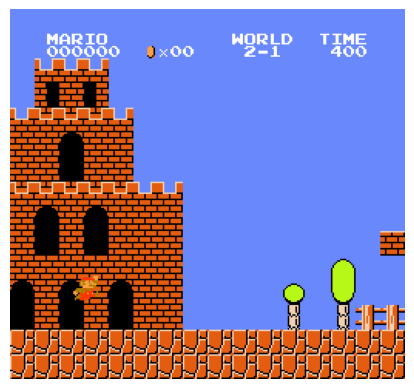

In [7]:
def see_world(test_env):
  obs = test_env.reset()
  for i in range(10):
      action = test_env.action_space.sample()
      obs, reward, done, info = test_env.step(action)

  from matplotlib import pyplot as plt
  if obs.shape[2] == 4:
    plt.imshow(obs[-1])
    plt.axis('off')
  else:
    plt.imshow(obs)
    plt.axis('off')
  plt.show()
print("WHAT WE SEE")
see_world(env)

WHAT MODEL SEE


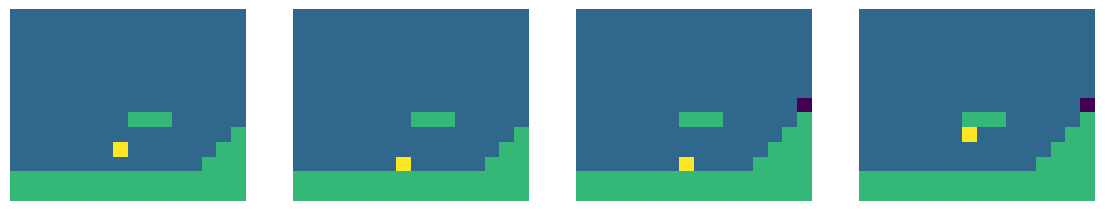

In [12]:
print("WHAT MODEL SEE")
fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    ax[i].imshow(state[:,:,n_stack-i-1], vmin=-1, vmax=2)
    ax[i].axis('off')
plt.show()

In [8]:
# Apply other wrapper functions
env_wrap = Monitor(env_wrap)  # for tensorboard log
env_wrap = DummyVecEnv([lambda: env_wrap])

# 3. Setup RL Model

In [23]:
# Callbacks

# Save intermediate models
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, 
                 starting_steps=0, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_steps = starting_steps

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls + int(self.starting_steps)))
            self.model.save(model_path)

        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [24]:
### MODIFY THESE TWO DIRECTORIES BEFORE TRAINING A NEW MODEL ###
MODEL_DIR = './models/NEW_MODEL_DIR2-1'
LOG_DIR = './logs/NEW_LOG_DIR'

In [25]:
model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4), tensorboard_log=LOG_DIR) 

In [26]:
callback = TrainAndLoggingCallback(check_freq=1e5, starting_steps=0, save_path=MODEL_DIR)

# Train the model

In [27]:
#model = PPO.load('./models/Best Models/level_1-4', env=env_wrap)

In [28]:
t_start = time.time()

model.learn(total_timesteps=20e6, callback=callback)

t_elapsed = time.time() - t_start

KeyboardInterrupt: 

# Save and load trained model

In [60]:
# Save model
model_path = os.path.join(MODEL_DIR, 'level_2-1')
model.save(model_path)

In [61]:
del model

In [63]:
# Load model
LOG_DIR = './logs/SAVED_LOG_DIR'
MODEL_DIR = './models/Best Models'

model_path = os.path.join(MODEL_DIR, 'level_2-1')
model = PPO.load(model_path, env=env_wrap)

# Open tensorboard

In [15]:
LOG_NAME = 'PPO_1'
TB_LOG = os.path.join(LOG_DIR, LOG_NAME)

!tensorboard --logdir={TB_LOG}

^C


# 4. Test the Trained Model

In [14]:
from stable_baselines3.common.evaluation import evaluate_policy

In [15]:
print(model.policy)

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=832, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=832, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


In [65]:
evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)

(2129.0, 0.0)

In [66]:
episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

D:\MarioPPO\Super-mario reinforcement learning\ppo\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Episode:1 Score:[2129.]
